## Clustering

In [1]:
# import libraries

import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

warnings.filterwarnings('ignore')

In [2]:
df= pd.read_csv("Impact_of_Remote_Work_on_Mental_Health.csv")
pd.set_option('display.max_columns', None)
df

df.columns= df.columns.str.strip().str.lower()
df.columns

Index(['employee_id', 'age', 'gender', 'job_role', 'industry',
       'years_of_experience', 'work_location', 'hours_worked_per_week',
       'number_of_virtual_meetings', 'work_life_balance_rating',
       'stress_level', 'mental_health_condition',
       'access_to_mental_health_resources', 'productivity_change',
       'social_isolation_rating', 'satisfaction_with_remote_work',
       'company_support_for_remote_work', 'physical_activity', 'sleep_quality',
       'region'],
      dtype='object')

In [3]:
df.drop('employee_id', axis=1, inplace= True)

df['mental_health_condition'].fillna('None', inplace= True)
df['mental_health_condition'].value_counts()

df['physical_activity'].fillna('None', inplace= True)
df['physical_activity'].value_counts()

physical_activity
Weekly    1755
None      1629
Daily     1616
Name: count, dtype: int64

In [4]:
clus= df.copy()
clus

,age,gender,job_role,industry,years_of_experience,work_location,hours_worked_per_week,number_of_virtual_meetings,work_life_balance_rating,stress_level,mental_health_condition,access_to_mental_health_resources,productivity_change,social_isolation_rating,satisfaction_with_remote_work,company_support_for_remote_work,physical_activity,sleep_quality,region
0,32,Non-binary,HR,Healthcare,13,Hybrid,47,7,2,Medium,Depression,No,Decrease,1,Unsatisfied,1,Weekly,Good,Europe
1,40,Female,Data Scientist,IT,3,Remote,52,4,1,Medium,Anxiety,No,Increase,3,Satisfied,2,Weekly,Good,Asia
2,59,Non-binary,Software Engineer,Education,22,Hybrid,46,11,5,Medium,Anxiety,No,No Change,4,Unsatisfied,5,None,Poor,North America
3,27,Male,Software Engineer,Finance,20,Onsite,32,8,4,High,Depression,Yes,Increase,3,Unsatisfied,3,None,Poor,Europe
4,49,Male,Sales,Consulting,32,Onsite,35,12,2,High,None,Yes,Decrease,3,Unsatisfied,3,Weekly,Average,North America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,32,Male,Sales,Consulting,4,Onsite,24,2,5,High,Burnout,Yes,Decrease,4,Neutral,1,Weekly,Average,Asia
4996,39,Female,Sales,Healthcare,27,Onsite,48,15,1,Low,Depression,Yes,Decrease,1,Satisfied,1,None,Average,Africa
4997,42,Female,Sales,Healthcare,21,Hybrid,34,1,4,High,Burnout,No,Increase,3,Satisfied,1,Daily,Poor,Oceania
4998,27,Female,Sales,Healthcare,26,Remote,58,0,5,Low,None,Yes,Increase,3,Unsatisfied,4,Daily,Average,Asia


In [5]:
num_cols= ['age', 'years_of_experience', 'hours_worked_per_week','number_of_virtual_meetings','work_life_balance_rating','social_isolation_rating', 'company_support_for_remote_work']
tot_len= 0
for i in df.columns:
    if i not in num_cols:
        print(f'\033[31m{i.upper()}\033[0m'.center(50, ' '))
        print(clus[i].value_counts())
        tot_len= tot_len+ clus[i].nunique()
        print()
        print()

                 GENDER                  
gender
Female               1274
Male                 1270
Prefer not to say    1242
Non-binary           1214
Name: count, dtype: int64


                JOB_ROLE                 
job_role
Project Manager      738
Sales                733
Designer             723
HR                   716
Software Engineer    711
Data Scientist       696
Marketing            683
Name: count, dtype: int64


                INDUSTRY                 
industry
Finance          747
IT               746
Healthcare       728
Retail           726
Education        690
Manufacturing    683
Consulting       680
Name: count, dtype: int64


              WORK_LOCATION              
work_location
Remote    1714
Hybrid    1649
Onsite    1637
Name: count, dtype: int64


              STRESS_LEVEL               
stress_level
High      1686
Medium    1669
Low       1645
Name: count, dtype: int64


         MENTAL_HEALTH_CONDITION         
mental_health_condition
Burnout       12

## One hot encoding variables with no inherent order

In [6]:
to_onehotencode= ['region', 'mental_health_condition', 'work_location', 'industry', 'job_role', 'gender']
ohe_prefix= ['region', 'mental', 'loc', 'ind', 'job', 'gen']
for i in range(len(to_onehotencode)):
    clus= clus.join(pd.get_dummies(clus[to_onehotencode[i]], prefix= ohe_prefix[i]).astype('int'))
    clus.drop(to_onehotencode[i], axis=1, inplace= True)


clus.columns= clus.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_')



## nominal and binary encoding variables with inherent order

In [7]:
def three_encode(df, col, x1, x2, x3, val1, val2, val3):
    return df[col].map({
        x1: val1,
        x2: val2,
        x3: val3
    })

def two_encode(df, col, val1):
    return df[col].apply(lambda x:1 if x==val1 else 0)

clus['sleep_quality']= three_encode(clus, 'sleep_quality', 'Poor','Average', 'Good', 0, 1, 2)
clus['satisfaction_with_remote_work']= three_encode(clus, 'satisfaction_with_remote_work', 'Unsatisfied','Neutral', 'Satisfied', 0, 1, 2)
clus['productivity_change']= three_encode(clus, 'productivity_change', 'Decrease','No Change', 'Increase', -1, 0, 1)
clus['stress_level']= three_encode(clus, 'stress_level', 'Low','Medium', 'High', 0, 1, 2)

clus['access_to_mental_health_resources']= two_encode(clus, 'access_to_mental_health_resources', 'Yes')
clus['physical_activity']= two_encode(clus, 'physical_activity', 'Daily')

clus


,age,years_of_experience,hours_worked_per_week,number_of_virtual_meetings,work_life_balance_rating,stress_level,access_to_mental_health_resources,productivity_change,social_isolation_rating,satisfaction_with_remote_work,company_support_for_remote_work,physical_activity,sleep_quality,region_africa,region_asia,region_europe,region_north_america,region_oceania,region_south_america,mental_anxiety,mental_burnout,mental_depression,mental_none,loc_hybrid,loc_onsite,loc_remote,ind_consulting,ind_education,ind_finance,ind_healthcare,ind_it,ind_manufacturing,ind_retail,job_data_scientist,job_designer,job_hr,job_marketing,job_project_manager,job_sales,job_software_engineer,gen_female,gen_male,gen_non_binary,gen_prefer_not_to_say
0,32,13,47,7,2,1,0,-1,1,0,1,0,2,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,40,3,52,4,1,1,0,1,3,2,2,0,2,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0
2,59,22,46,11,5,1,0,0,4,0,5,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,27,20,32,8,4,2,1,1,3,0,3,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
4,49,32,35,12,2,2,1,-1,3,0,3,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,32,4,24,2,5,2,1,-1,4,1,1,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4996,39,27,48,15,1,0,1,-1,1,2,1,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0
4997,42,21,34,1,4,2,0,1,3,2,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0
4998,27,26,58,0,5,0,1,1,3,0,4,1,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0


## Standard scaling the numerical columns

In [8]:
cat_cols=[]
for i in clus.columns:
    if i not in num_cols:
        cat_cols.append(i)
        
sc= StandardScaler()
clus_num = clus[num_cols]
clus_cat = clus[cat_cols]

clus_num_sc = sc.fit_transform(clus_num)
clus_sc= pd.DataFrame(clus_num_sc, columns= clus_num.columns)
clus_sc= pd.concat([clus_sc, clus_cat.reset_index(drop=True)], axis=1)

clus_sc

,age,years_of_experience,hours_worked_per_week,number_of_virtual_meetings,work_life_balance_rating,social_isolation_rating,company_support_for_remote_work,stress_level,access_to_mental_health_resources,productivity_change,satisfaction_with_remote_work,physical_activity,sleep_quality,region_africa,region_asia,region_europe,region_north_america,region_oceania,region_south_america,mental_anxiety,mental_burnout,mental_depression,mental_none,loc_hybrid,loc_onsite,loc_remote,ind_consulting,ind_education,ind_finance,ind_healthcare,ind_it,ind_manufacturing,ind_retail,job_data_scientist,job_designer,job_hr,job_marketing,job_project_manager,job_sales,job_software_engineer,gen_female,gen_male,gen_non_binary,gen_prefer_not_to_say
0,-0.796378,-0.480088,0.622767,-0.120587,-0.697830,-1.429785,-1.435264,1,0,-1,0,0,2,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,-0.088093,-1.478151,1.044388,-0.767744,-1.406862,0.004446,-0.720420,1,0,1,2,0,2,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0
2,1.594083,0.418168,0.538443,0.742290,1.429268,0.721562,1.424112,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,-1.239056,0.218556,-0.642094,0.095132,0.720235,0.004446,-0.005576,2,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
4,0.708727,1.416231,-0.389122,0.958009,-0.697830,0.004446,-0.005576,2,1,-1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-0.796378,-1.378345,-1.316687,-1.199183,1.429268,0.721562,-1.435264,2,1,-1,1,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4996,-0.176629,0.917200,0.707091,1.605166,-1.406862,-1.429785,-1.435264,0,1,-1,2,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0
4997,0.088978,0.318362,-0.473446,-1.414902,0.720235,0.004446,-1.435264,2,0,1,2,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0
4998,-1.239056,0.817393,1.550332,-1.630621,1.429268,0.004446,0.709268,0,1,1,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0


2   0.31445345682271725
3   0.33814538524696347
4   0.3237557357488821
5   0.3156101871983834
6   0.3323992368100739
7   0.32785941239106803
8   0.3226601103255438
9   0.3203021398421603
10   0.3249536788648505


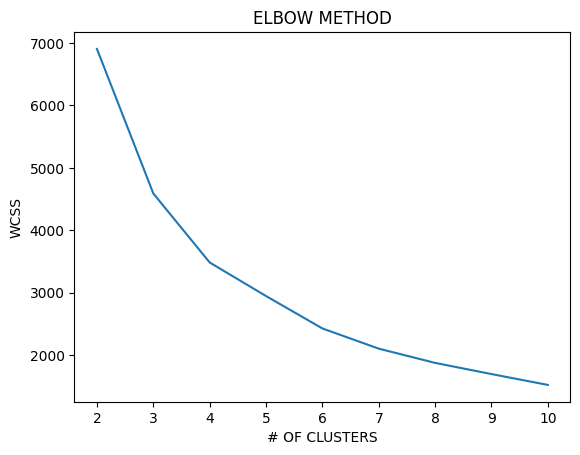

In [9]:
pca= PCA(n_components= 2)
clus_pca= pca.fit_transform(clus_sc)
clus_pca

wcss=[]
for i in range(2, 11):
    km= KMeans(n_clusters= i)
    km.fit(clus_pca)
    print(i, " ", silhouette_score(clus_pca, km.labels_))
    wcss.append(km.inertia_)
    
plt.plot(range(2, 11), wcss)
plt.title('ELBOW METHOD')
plt.xlabel('# OF CLUSTERS')
plt.ylabel('WCSS')
plt.show()

km= KMeans(n_clusters=3)
km.fit(clus_pca)
y_pred= km.predict(clus_pca)
df['cluster']= y_pred

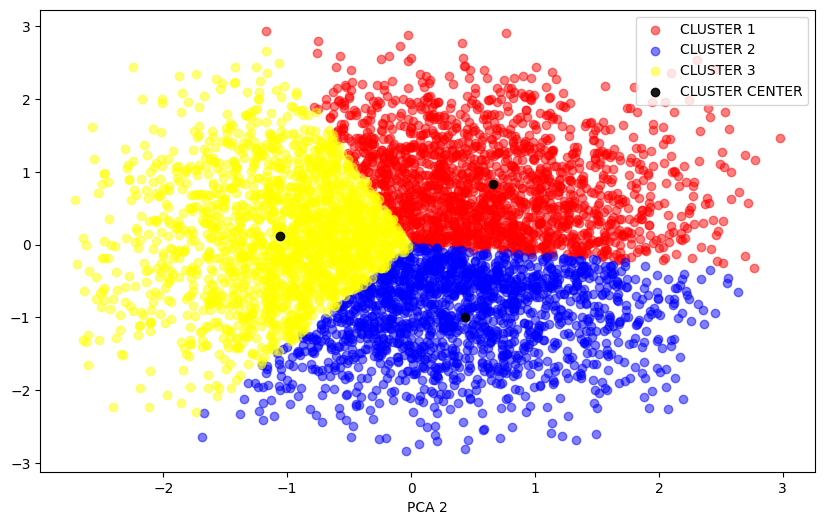

In [10]:
plt.figure(figsize=(10,6))
plt.scatter(clus_pca[y_pred==0, 0], clus_pca[y_pred==0, 1], color='red', label='CLUSTER 1', alpha= 0.5)
plt.scatter(clus_pca[y_pred==1, 0], clus_pca[y_pred==1, 1], color='blue', label='CLUSTER 2', alpha= 0.5)
plt.scatter(clus_pca[y_pred==2, 0], clus_pca[y_pred==2, 1], color='yellow', label='CLUSTER 3', alpha= 0.5)
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], color='black', label='CLUSTER CENTER', alpha= 0.9)
plt.legend()
plt.xlabel('PCA 1')
plt.xlabel('PCA 2')
plt.show()

In [11]:
num_cols.append('cluster')
df_cluster = df[num_cols].groupby('cluster').mean().T
df_cluster

clus_0 = df[df['cluster']==0]
clus_1 = df[df['cluster']==1]
clus_2 = df[df['cluster']==2]

## Functions to chart

In [12]:
def pie_chart(df, col, axes, clusterno):
    s= clusterno+ ' '+col
    cnts = df[col].value_counts()
    axes.pie(cnts, labels=cnts.index, autopct='%.1f%%', startangle=90)
    axes.set_title( s.upper(), fontsize=14, fontweight='bold')
    
def bar_plt(df, col, axes, clusterno):
    s= clusterno+ ' '+col
    cnts = df[col].value_counts().head(5)
    bars = axes.bar(cnts.index, cnts.values)
    axes.bar_label(bars)
    axes.set_title(s.upper(), fontsize=14, fontweight='bold')
    axes.get_yaxis().set_visible(False)
    axes.set_xlabel(col)

### DEMOGRPAHY

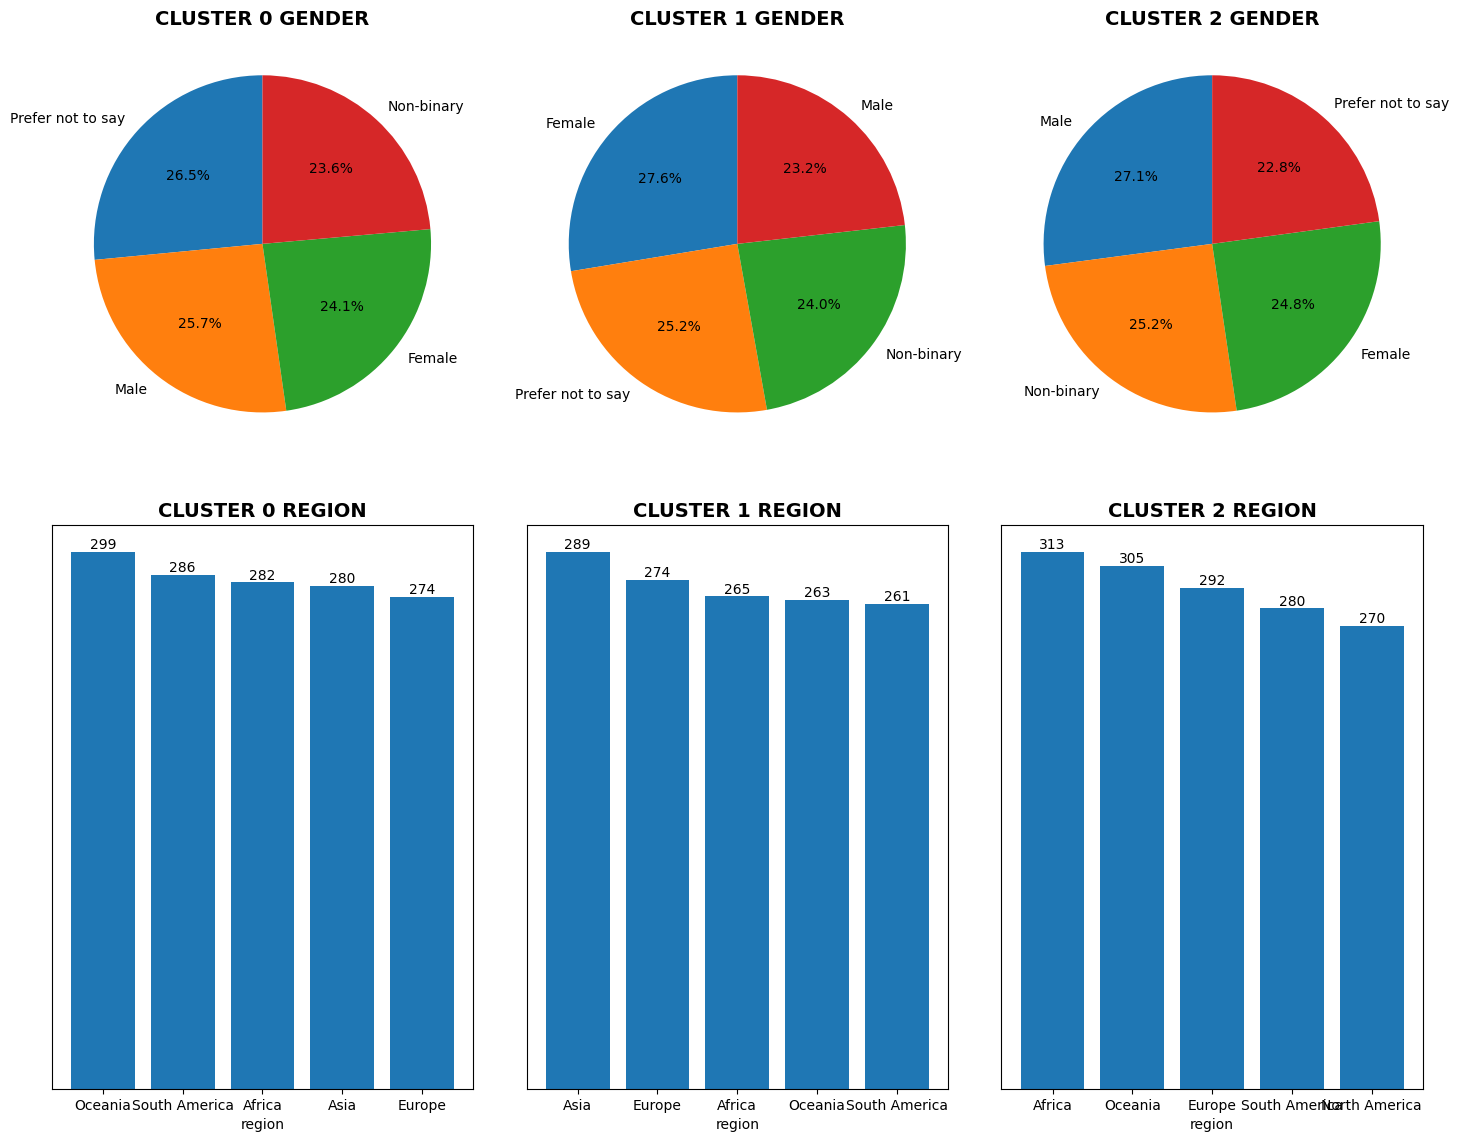

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 12))
pie_chart(clus_0, 'gender', axes[0, 0], 'cluster 0')
pie_chart(clus_1, 'gender', axes[0, 1], 'cluster 1')
pie_chart(clus_2, 'gender', axes[0, 2], 'cluster 2')


bar_plt(clus_0, 'region', axes[1, 0], 'cluster 0')
bar_plt(clus_1, 'region', axes[1, 1], 'cluster 1')
bar_plt(clus_2, 'region', axes[1, 2], 'cluster 2')

plt.tight_layout()
plt.show()

Most of cluster 0 and 1 are male where cluster 2 have more female employees. The percent of non binary employees through the 3 clusters are more or less uniform

Most members of cluster 1 and 2 belong to central and east whereas those from cluster 0 are distributed across South America as well.

### Job

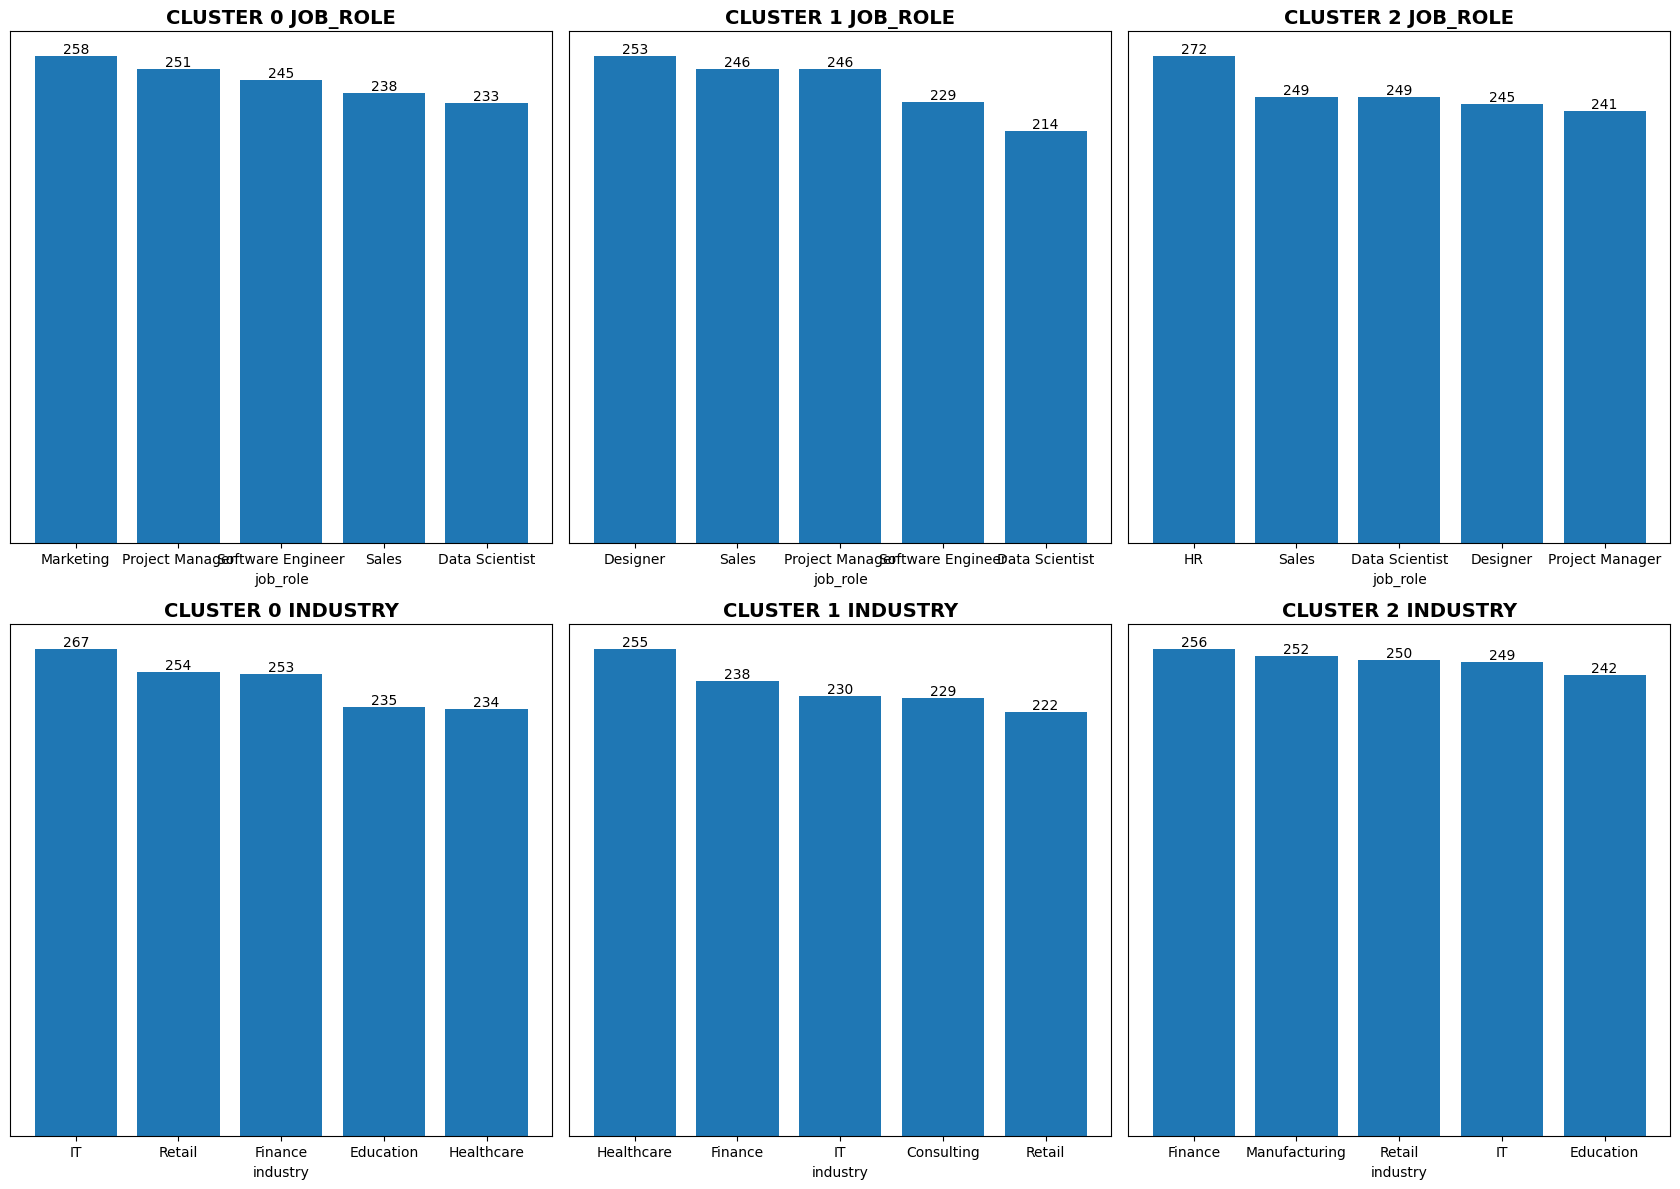

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(17, 12))
bar_plt(clus_0, 'job_role', axes[0, 0], 'cluster 0')
bar_plt(clus_1, 'job_role', axes[0, 1], 'cluster 1')
bar_plt(clus_2, 'job_role', axes[0, 2], 'cluster 2')


bar_plt(clus_0, 'industry', axes[1, 0], 'cluster 0')
bar_plt(clus_1, 'industry', axes[1, 1], 'cluster 1')
bar_plt(clus_2, 'industry', axes[1, 2], 'cluster 2')



plt.tight_layout()
plt.show()

### WORK AND SATISFACTION

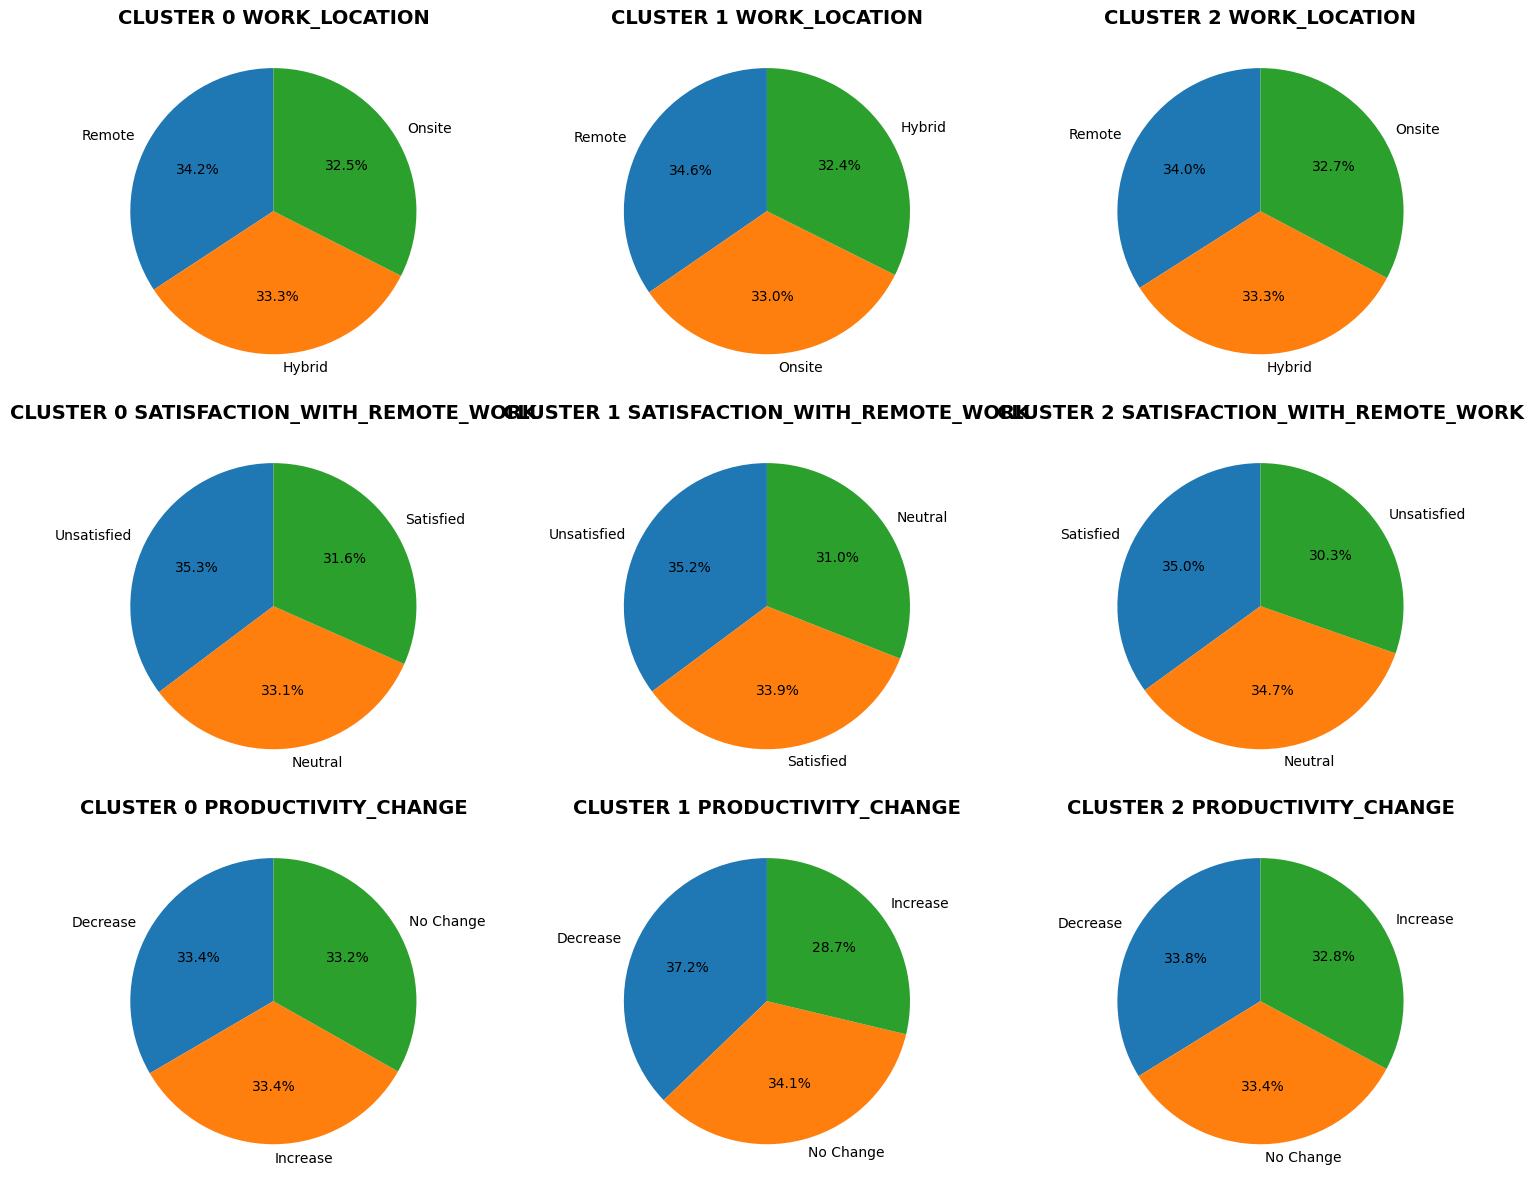

In [15]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
pie_chart(clus_0, 'work_location', axes[0, 0], 'cluster 0')
pie_chart(clus_1, 'work_location', axes[0, 1], 'cluster 1')
pie_chart(clus_2, 'work_location', axes[0, 2], 'cluster 2')


pie_chart(clus_0, 'satisfaction_with_remote_work', axes[1, 0], 'cluster 0')
pie_chart(clus_1, 'satisfaction_with_remote_work', axes[1, 1], 'cluster 1')
pie_chart(clus_2, 'satisfaction_with_remote_work', axes[1, 2], 'cluster 2')

pie_chart(clus_0, 'productivity_change', axes[2, 0], 'cluster 0')
pie_chart(clus_1, 'productivity_change', axes[2, 1], 'cluster 1')
pie_chart(clus_2, 'productivity_change', axes[2, 2], 'cluster 2')

plt.tight_layout()
plt.show()

Work location is more or less similiar across the 3 clusters.

Cluster 2 which is predominantly the healthcare sector has the highest percent of unsatisfied employees and evidently has the highest decrease in productivity

Cluster 0 on the other hand consisting of predominantly IT sector has the higher percent of satisfied employees as well highest increase in productivity

This shows that the industry may have an impact on the satisfaction with remote work of employees which in turn affects productivity. We shall test it in theory later

### Mental Health condition

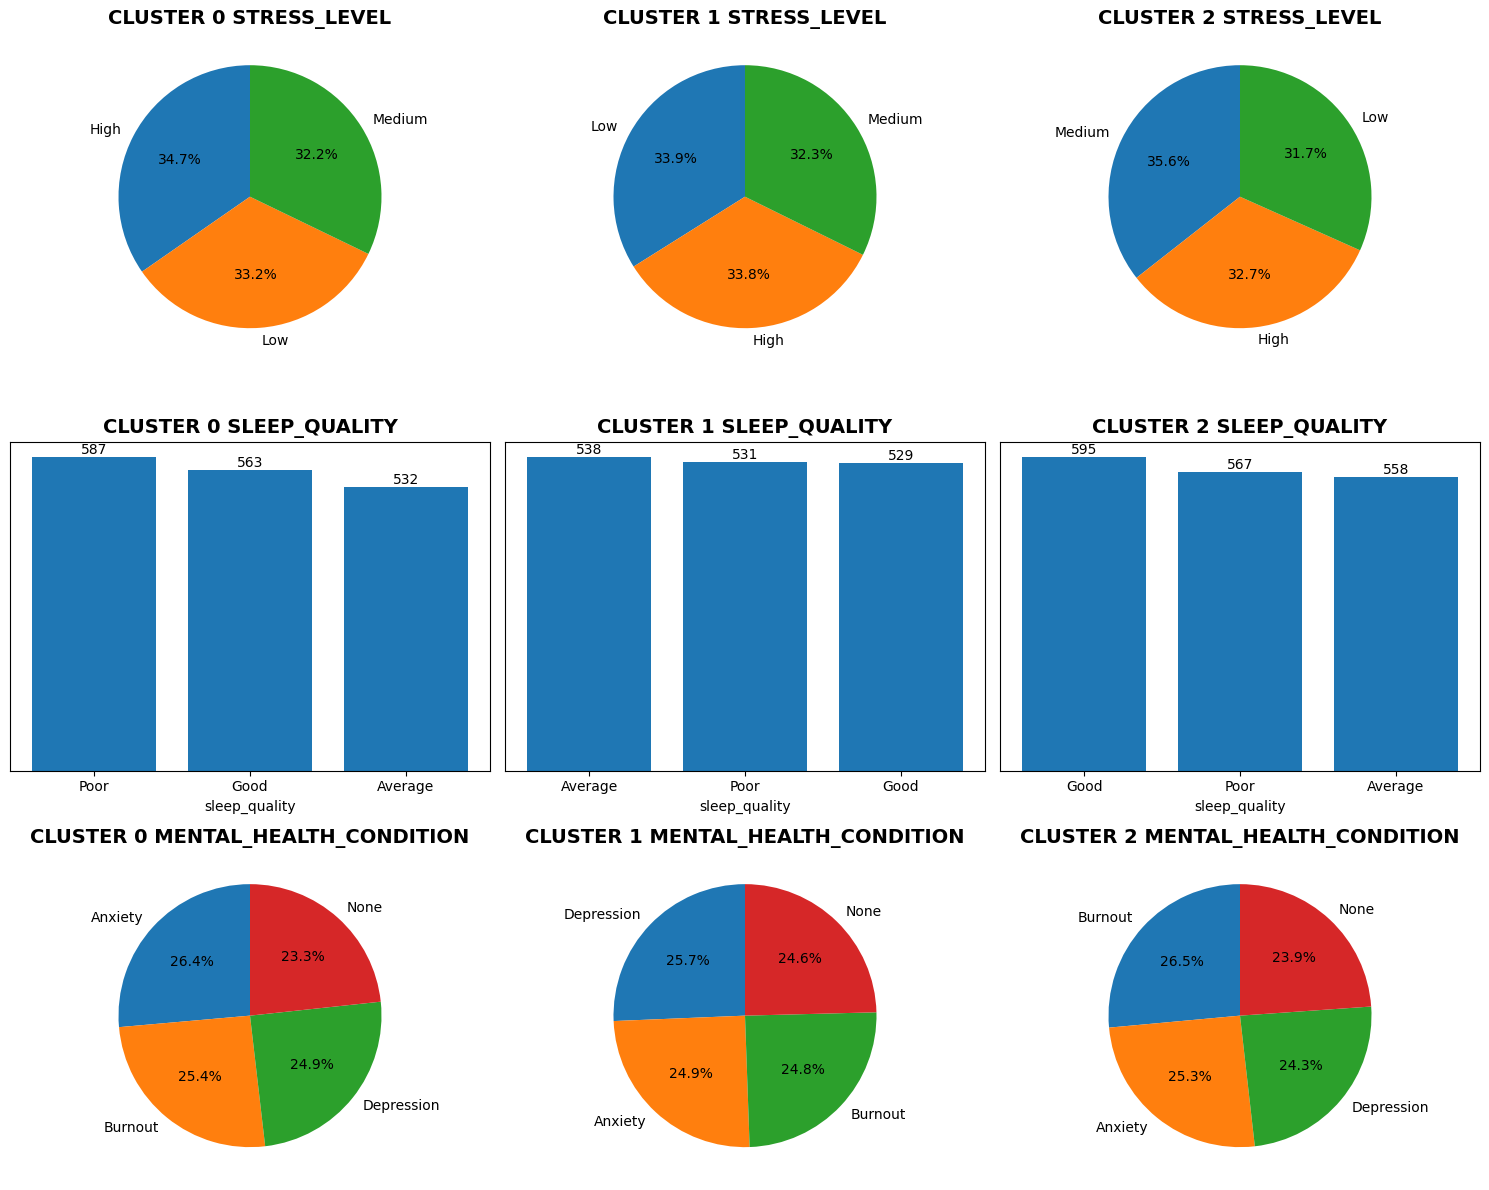

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
pie_chart(clus_0, 'stress_level', axes[0, 0], 'cluster 0')
pie_chart(clus_1, 'stress_level', axes[0, 1], 'cluster 1')
pie_chart(clus_2, 'stress_level', axes[0, 2], 'cluster 2')




bar_plt(clus_0, 'sleep_quality', axes[1, 0], 'cluster 0')
bar_plt(clus_1, 'sleep_quality', axes[1, 1], 'cluster 1')
bar_plt(clus_2, 'sleep_quality', axes[1, 2], 'cluster 2')



pie_chart(clus_0, 'mental_health_condition', axes[2, 0], 'cluster 0')
pie_chart(clus_1, 'mental_health_condition', axes[2, 1], 'cluster 1')
pie_chart(clus_2, 'mental_health_condition', axes[2, 2], 'cluster 2')

plt.tight_layout()
plt.show()

INSIGHT

CLUSTER 0: Cluster 0 consists of a higher proportion of employees satisfied with their remote work, who show an increase in productivity. But they face high stress levels and have poor sleep quality. This may be due to the highest working hours per week (averages around 45 hours) despite having lowest work experience years (averages around 11 years)

This increased work load, high stress and poor sleep quality may be some of the reasons why most of them suffer from anxiety.

CLUSTER 1: Cluster 1 consists of employees with the highest proportion of employees satisfied with their remote work but show a predominant decrease in their productivity. They also show the lowest average work life balance rating as well as highest average isolation rating. Employees in cluster 1 mostly face medium stress levels and good sleep quality.

They have the second highest work hours per week and virtual meetings attended. Therefore, this may contribute to the high percent of burn out aong the employees.

CLUSTER 2: Cluster 2 has the highest proportion of unsatisfied employees with remote work, highest decrease in productivity and the highest no of virtual meetings attended. They have sleep quality ranging from average to poor and have high stress levels.

All these factors contribute to the high percent of depression and anxiety faced by the employees.

| Cluster    | Employee Satisfaction          | Productivity   | Stress Levels | Sleep Quality      | Work Hours per Week | Work Experience (Years) | Work-life Balance | Isolation   | Virtual Meetings | Issues                                |
|------------|--------------------------------|----------------|---------------|--------------------|----------------------|-------------------------|-------------------|-------------|------------------|---------------------------------------|
| Cluster 0  | High satisfaction             | Increased      | High          | Poor               | 45 hours (highest)  | 11 years (lowest)       | High              | Lowest      | 5 meets          | Anxiety due to high stress and poor sleep |
| Cluster 1  | Highest satisfaction          | Decreased      | Medium        | Good               | 38 hours            | 19 years                | Lowest rating     | Highest     | 7 meets          | Burnout                               |
| Cluster 2  | Lowest satisfaction           | Highest decrease | High        | Average to poor    | 34 hours            | 23 years (Highest)      | Highest           | Low         | 10 meets (Highest) | Depression and anxiety               |
